# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-14

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg containing spots  
> Output file(s): .csv file containing data on all detected spots  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl, pathlib, math 

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [28]:
# Importing dependencies
import imageio.v3 as iio
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import ipympl
from pathlib import Path
import math
%matplotlib widget

## User Input

In [29]:
inputfile=Path(r"test_images\edge_halo.tif")
outputfolder=Path(r"output")

first_spot="A1"
last_spot="P20"

### Extracting Information from User Input

In [30]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

# Determining the indexes of the first and last row
firstrow_nr=row_conv[first_spot[0].lower()]
lastrow_nr=row_conv[last_spot[0].lower()]
rowcount=lastrow_nr-firstrow_nr+1
rowstart=math.floor((firstrow_nr)/10)*10

# Determining the indexes of the first and last column
firstcol_nr=int(first_spot[1:])
lastcol_nr=int(last_spot[1:])
colcount=lastcol_nr-firstcol_nr+1
colstart=math.floor((firstcol_nr)/10)*10

# Calculating the number of total spots
nr_spots=rowcount*colcount

## Loading the Image File

[Text(0.5, 1.0, 'Grayscale Image')]

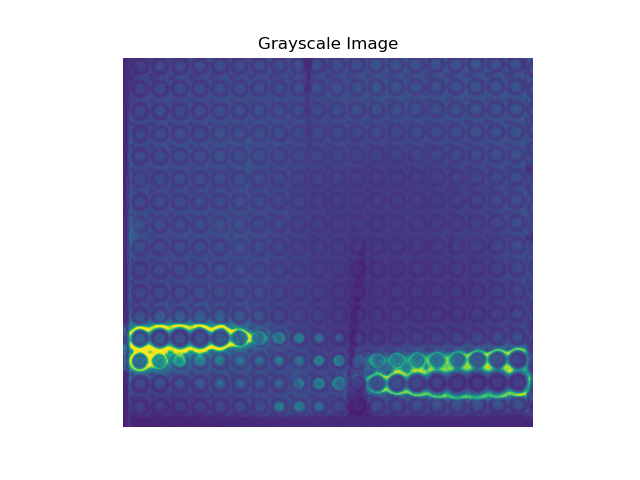

In [31]:
load=iio.imread(inputfile)

# Check if image has an alpha value and convert image to RGB.
if load.shape[2]==4:
    raw_img=skimage.color.rgb2gray(load[:,:,0:3])

# Convert RGB images to grayscale.
elif load.shape[2]==3:
    raw_img=skimage.color.rgb2gray(load)

# Invert the intensity values. Comment out if you do not wish to invert the image.
raw_img=skimage.util.invert(raw_img)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


## Inital Spot Detection

,x_coord,y_coord,radius,hough_peak_int
0,942,773,24,0.756944
1,729,1385,23,0.750000
2,623,530,23,0.750000
3,730,1018,24,0.743056
4,519,1263,24,0.743056
5,628,1751,24,0.736111
6,624,1019,24,0.722222
7,91,290,24,0.722222
8,944,1629,24,0.715278
9,1254,163,23,0.705882


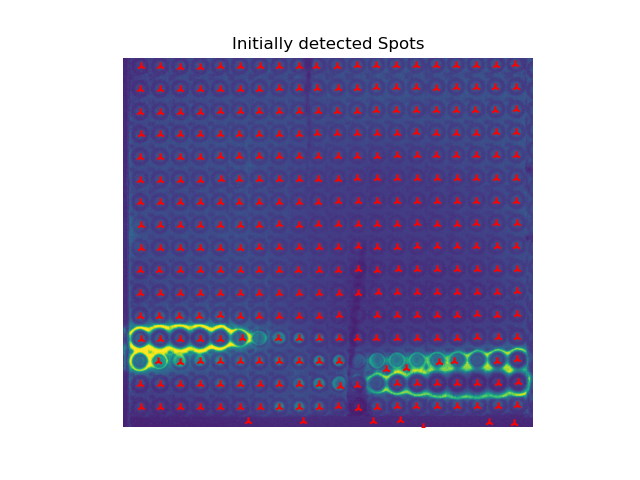

In [32]:
# Edge detection in Image using the Canny method.
histeq_img=skimage.filters.rank.equalize(skimage.util.img_as_ubyte(raw_img),skimage.morphology.disk(50))
edges=skimage.feature.canny(
    image=histeq_img,
    sigma=10,
    low_threshold=0.001,
    high_threshold=0.001
    )

# Range of Radii that are tested during inital spotdetection.
tested_radii=np.arange(20,31)

# Hough transform for a circle of the edge-image and peak detection to find circles in earlier defined range of radii.
spot_hough=skimage.transform.hough_circle(edges,tested_radii)
accums,spot_x,spot_y,spot_rad=skimage.transform.hough_circle_peaks(
    hspaces=spot_hough,
    radii=tested_radii,
    total_num_peaks=nr_spots,
    min_xdistance=70,
    min_ydistance=70,
    threshold=0.3*spot_hough.max()
    )

# Storing results in DataFrame.
det_spot=pd.DataFrame({"x_coord":spot_x,"y_coord":spot_y,"radius":spot_rad,"hough_peak_int":accums})

# Displaying image with initally detected spots.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Initially detected Spots")
ax.scatter(spot_x,spot_y,marker="2",c="red")

# Displaying the first 10 Rows of the Dataframe.
det_spot.head(10)

## Grid Detection

Spot at Coordinates (1610, 1983) could not be drawn: Out of Bounds.


[Text(0.5, 1.0, 'Detected Spot-Grid')]

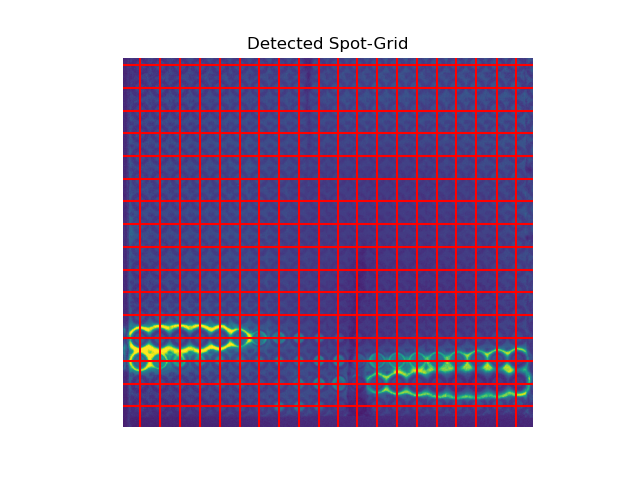

In [33]:
def draw_spot(image,x_coord,y_coord,radius,value):
    rr,cc=skimage.draw.disk((y_coord,x_coord),radius)
    try:
        image[rr,cc]=value
    except:
        print(f"Spot at Coordinates ({x_coord}, {y_coord}) could not be drawn: Out of Bounds.")
    return image

def detect_gridlines(img,max_tilt):
    line_img,ang,dist=skimage.transform.hough_line(img)
    line_img[:,np.r_[max_tilt:89-max_tilt,91+max_tilt:180-max_tilt]]=0
    accum,angle,distance=skimage.transform.hough_line_peaks(line_img,ang,dist,min_distance=80,threshold=0.2*line_img.max())
    return angle,distance

class line:
    def __init__(self, angle, distance):
        self.dist=distance
        self.angle=angle
        self.slope=np.tan(angle+np.pi/2)
        (x0, y0)=distance*np.array([np.cos(angle),np.sin(angle)])
        self.y_int=y0-self.slope*x0
    
    def __repr__(self):
        return f"y={self.slope:.2f}*x+{self.y_int:.2f}"

    def intersect(self,line2):
        x=(line2.y_int-self.y_int)/(self.slope-line2.slope)
        y=self.slope*x+self.y_int
        return x,y

# Define the maximum allowed tilt of the Grid.
max_allowed_tilt=5

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for idx in det_spot.index:
    dot_img=draw_spot(dot_img,det_spot.loc[idx,"x_coord"],det_spot.loc[idx,"y_coord"],5,255)

# Detect lines laying on the 
angle, dist=detect_gridlines(dot_img, max_tilt=max_allowed_tilt)

# Create a List of vertical and horizontal line objects.
hor_line=[line(a,d) for a,d in zip(angle,dist) if np.abs(np.rad2deg(a))<=max_allowed_tilt]
vert_line=[line(a,d) for a,d in zip(angle,dist) if np.abs(np.rad2deg(a))>=90-max_allowed_tilt]

# Calculation of the coordinates of all gridline-intersections.
intersections=[]
for h_l in hor_line:
    for v_l in vert_line:
        intersections.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
ax.imshow(raw_img)
for item in hor_line+vert_line:
    ax.axline((0,item.y_int), slope=item.slope,c="r")
ax.set(ylim=[raw_img.shape[0],0],xlim=[0,raw_img.shape[1]])
ax.axis("off")
ax.set(title="Detected Spot-Grid")

## Spot Correction

,x_coord,y_coord,radius,hough_peak_int,min_griddist,note
0,942,773,24,0.756944,1.0,kept
1,729,1385,23,0.750000,3.605551,kept
2,623,530,23,0.750000,4.472136,kept
3,730,1018,24,0.743056,2.236068,kept
4,519,1263,24,0.743056,3.162278,kept
...,...,...,...,...,...,...
315,1256,1629,23,NaN,0,backfilled
316,1468,1629,23,NaN,0,backfilled
317,1788,1629,23,NaN,0,backfilled
318,1153,1750,23,NaN,0,backfilled


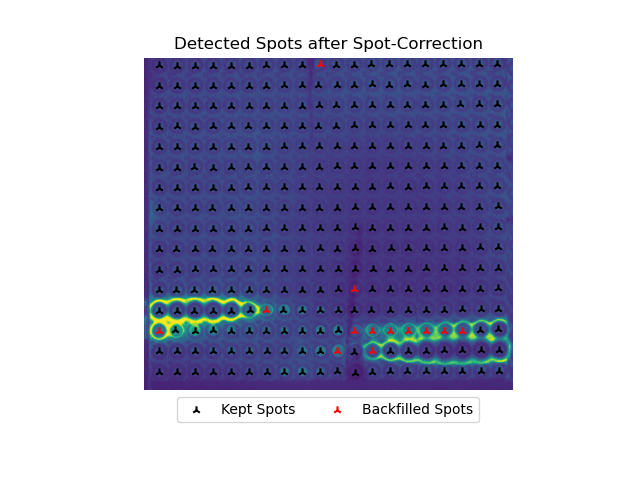

In [34]:
# Add relevant columns to spot-dataframe for spot correction.
det_spot["min_griddist"]=10000 # Placeholder value to be replaced
det_spot["note"]="kept"

#Loop over all gridpoints and detected spots:
for gridpoint in intersections:
    dist_list=[]
    for idx in det_spot.index:
        spot=det_spot.loc[idx]
        # Calculate the distance between a gridpoint and a spot.
        pointdist=np.linalg.norm(np.array(gridpoint)-np.array((spot["x_coord"],spot["y_coord"])))
        # Append to distance list needed later.
        dist_list.append(pointdist)

        # Add the distance of the specific spot to the current gridpoint if it is smaller than all previously tested gridpoints.
        if pointdist<spot["min_griddist"]: det_spot.loc[idx,"min_griddist"]=pointdist

    # If the minimum distance of a gridpoint to all detected spots is greater than 10, no spot was determined for this gridpoint with reasonable accuracy.
    if min(dist_list)>=12:
        # Backfilling spot at the location of the gridpoint
        new_spot=pd.Series({"x_coord":int(gridpoint[0]),"y_coord":int(gridpoint[1]),"radius":int(spot_rad.mean()),"min_griddist":0,"note":"backfilled"})
        det_spot=pd.concat([det_spot,new_spot.to_frame().T],ignore_index=True)

# If the minimum distance of an initally detected spot to all gridpoints is greater than 10, it probably was falsely detected as a spot. --> Removal of the spot.
corr_spot=det_spot[det_spot["min_griddist"]<12].reset_index(drop=True).copy()

fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(corr_spot.loc[corr_spot["note"]=="kept","x_coord"],corr_spot.loc[corr_spot["note"]=="kept","y_coord"],marker="2",c="k",label="Kept Spots")
ax.scatter(corr_spot.loc[corr_spot["note"]=="backfilled","x_coord"],corr_spot.loc[corr_spot["note"]=="backfilled","y_coord"],marker="2",c="r",label="Backfilled Spots")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True,ncol=5)
ax.axis("off")
ax.set(title="Detected Spots after Spot-Correction")
corr_spot

## Halo Detection

[Text(0.5, 1.0, 'Detected Halos with corresponding Radius')]

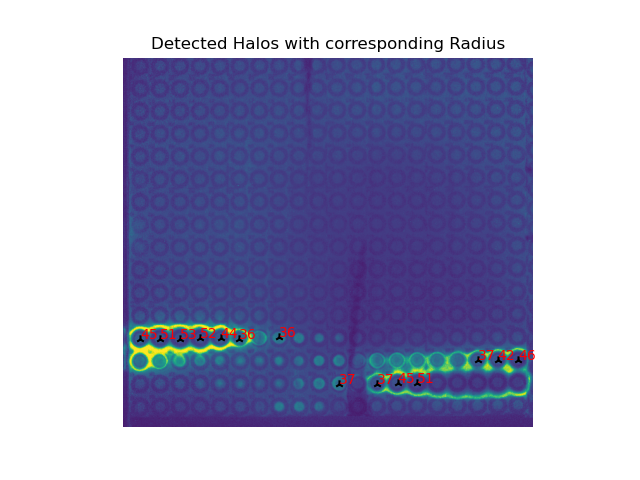

In [35]:
# Create a mask of the image only containing halos.
halo_mask=raw_img<skimage.filters.threshold_yen(raw_img)

# Applying the mask to the histeq_img yields more consistent results for circle detection. The mask itself yields better results when calculated from the raw image.
halo_img=histeq_img.copy()
halo_img[halo_mask]=0

# Canny edge detection and follow up circle detection using hough transform.
halo_edge=skimage.feature.canny(halo_img,10,10,60)
halo_radii=np.arange(35,70) # Radii tested for.
halo_hough=skimage.transform.hough_circle(halo_edge,halo_radii)

h_accum,h_x,h_y,h_radii=skimage.transform.hough_circle_peaks(
    halo_hough,
    halo_radii,
    min_xdistance=70,
    min_ydistance=70,
    threshold=0.5*halo_hough.max()
    )

# Saving all detected halos in a Dataframe
ab_halo=pd.DataFrame({"x_coord":h_x,"y_coord":h_y,"radius":h_radii})

# Displaying all detected Halos with their respective radii.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(h_x,h_y,marker="2",c="k")
for x,y,rad in zip(h_x,h_y,h_radii):
    ax.text(x, y, f'{rad}',c="r")
ax.axis("off")
ax.set(title="Detected Halos with corresponding Radius")

## Halo Assignment

In [36]:
# Create a new column for halos in spot DataFrame
corr_spot["halo_rad"]=np.nan

# Loop over all detected halos and all spots
for h_idx in ab_halo.index:
    # Exctract halo coordinates
    h_coord=np.array((ab_halo.loc[h_idx,"x_coord"],ab_halo.loc[h_idx,"y_coord"]))
    
    for s_idx in corr_spot.index:
        # Extract spot coordinates
        s_coord=np.array((corr_spot.loc[s_idx,"x_coord"],corr_spot.loc[s_idx,"y_coord"]))
        
        # If the distance between the current halo and the current spot is below a threshold, the halo is considered part of the spot.
        if np.linalg.norm(h_coord-s_coord)< 20:
            corr_spot.loc[s_idx,"halo_rad"]=ab_halo.loc[h_idx,"radius"]

corr_spot

,x_coord,y_coord,radius,hough_peak_int,min_griddist,note,halo_rad
0,942,773,24,0.756944,1.0,kept,NaN
1,729,1385,23,0.750000,3.605551,kept,NaN
2,623,530,23,0.750000,4.472136,kept,NaN
3,730,1018,24,0.743056,2.236068,kept,NaN
4,519,1263,24,0.743056,3.162278,kept,NaN
...,...,...,...,...,...,...,...
315,1256,1629,23,NaN,0,backfilled,NaN
316,1468,1629,23,NaN,0,backfilled,NaN
317,1788,1629,23,NaN,0,backfilled,NaN
318,1153,1750,23,NaN,0,backfilled,37.0


## Spot Sorting

In [37]:
# Calculation of Sum and Difference of x and y coordinates for every spot. Required to find the top left and top right spots in the DataFrame.
corr_spot["x+y"]=corr_spot["x_coord"]+corr_spot["y_coord"]
corr_spot["x-y"]=corr_spot["x_coord"]-corr_spot["y_coord"]

#col=["row","column","x_coord","y_coord","radius","note"]
sort_spot=pd.DataFrame(columns=["row_letter","row","column"])

# Loop Through the algorithm until all spots have been sorted:
row_nr=firstrow_nr
while len(corr_spot)>0:
    # Empty DataFrame for spots of the current top row.
    spotrow=pd.DataFrame()
    
    # The top left spot must have the lowest sum of x and y coordinate.
    idx_topleft=corr_spot["x+y"].sort_values().index[0]
    topleft_coord=np.array((corr_spot.loc[idx_topleft,"x_coord"],corr_spot.loc[idx_topleft,"y_coord"]))
    
    # The top right spot must have the highest difference between the x and y coordinate.
    idx_topright=corr_spot["x-y"].sort_values().index[-1]
    topright_coord=np.array((corr_spot.loc[idx_topright,"x_coord"],corr_spot.loc[idx_topright,"y_coord"]))

    # Loop through all spot in the DataFrame
    col_nr=firstcol_nr
    for idx in corr_spot.index:
        # Extract coordinates of current spot
        spot=corr_spot.loc[idx]
        spot_coord=np.array((spot["x_coord"],spot["y_coord"]))

        # Calculate the distance of the current spot to a line that goes through the left most and right most spot of the current row
        row_dist=np.linalg.norm(np.cross(np.subtract(spot_coord,topleft_coord),np.subtract(topright_coord,topleft_coord))/np.linalg.norm(np.subtract(topright_coord,topleft_coord)))

        # If the distance between the spot and the line is smaller than the spots radius, the spot must lie within the row
        if row_dist<=spot["radius"]:
            # Add spot to current row and remove it from the DataFrame of unsorted spots
            spotrow=pd.concat([spotrow,spot.to_frame().T])
            corr_spot.drop(idx, inplace=True)
            col_nr+=1
    
    # Sort spots in current row from left to right and add row + column index.
    spotrow.sort_values("x_coord",ascending=True,inplace=True)
    spotrow["row"]=row_nr
    spotrow["row_letter"]=row_conv_inv[row_nr].upper()
    spotrow["column"]=range(firstcol_nr,col_nr)

    # Add row to the DataFrame of sorted spots
    sort_spot=pd.concat([sort_spot,spotrow],ignore_index=True)

    row_nr+=1
    if row_nr>1000: break # Break the loop if not all spots can be assigned to a row.

sort_spot

,row_letter,row,column,x_coord,y_coord,radius,hough_peak_int,min_griddist,note,halo_rad,x+y,x-y
0,A,1,1,93,46,23,0.536765,6.324555,kept,NaN,139,47
1,A,1,2,199,47,23,0.536765,7.615773,kept,NaN,246,152
2,A,1,3,307,50,25,0.444444,10.440307,kept,NaN,357,257
3,A,1,4,411,48,24,0.590278,8.062258,kept,NaN,459,363
4,A,1,5,519,47,24,0.569444,7.071068,kept,NaN,566,472
...,...,...,...,...,...,...,...,...,...,...,...,...
315,P,16,16,1684,1869,25,0.458333,3.605551,kept,NaN,3553,-185
316,P,16,17,1793,1869,25,0.423611,5.830952,kept,NaN,3662,-76
317,P,16,18,1900,1869,24,0.388889,5.0,kept,NaN,3769,31
318,P,16,19,2014,1868,20,0.416667,9.848858,kept,NaN,3882,146


## Determination of Spot-Intensities

column,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
row_letter,,,,,,,,,,,,,,,,,,,,
A,0.558538,0.576549,0.578024,0.579968,0.584182,0.583514,0.584312,0.582255,0.583948,0.580511,0.585484,0.587247,0.595086,0.592189,0.591761,0.592807,0.589557,0.597503,0.593460,0.590518
B,0.566963,0.578083,0.581645,0.582243,0.586320,0.584475,0.585306,0.586108,0.587362,0.587488,0.588940,0.591294,0.600251,0.593420,0.592803,0.588981,0.589644,0.595286,0.595169,0.598598
C,0.574319,0.583251,0.580004,0.583704,0.583734,0.586488,0.588599,0.587575,0.586894,0.582708,0.586508,0.587748,0.590884,0.590035,0.587708,0.588336,0.592385,0.591763,0.593991,0.597852
D,0.576802,0.583085,0.586019,0.584087,0.592533,0.589524,0.589595,0.586106,0.581562,0.581790,0.579174,0.579172,0.580568,0.578942,0.580604,0.584116,0.584542,0.589494,0.592868,0.596990
E,0.580299,0.585083,0.588405,0.583649,0.592060,0.587910,0.589371,0.581437,0.578073,0.572824,0.574600,0.567999,0.566191,0.566825,0.571302,0.573939,0.578818,0.582643,0.588130,0.592062
F,0.578414,0.584825,0.584964,0.583926,0.588185,0.587777,0.584657,0.578329,0.571575,0.566292,0.566114,0.560421,0.557172,0.559277,0.561588,0.563871,0.568197,0.572862,0.582463,0.587476
G,0.578449,0.583924,0.583421,0.586021,0.585465,0.587530,0.584065,0.573998,0.571335,0.563867,0.562077,0.557980,0.555545,0.558275,0.557519,0.558800,0.563205,0.569472,0.578097,0.585397
H,0.592001,0.583693,0.583532,0.586829,0.588783,0.591272,0.580081,0.577059,0.566055,0.561952,0.557560,0.555255,0.553749,0.555693,0.555960,0.557451,0.560439,0.566700,0.571545,0.587171
I,0.583926,0.579932,0.584306,0.586035,0.586684,0.589844,0.581823,0.573359,0.565540,0.560370,0.555988,0.549044,0.550668,0.552428,0.552448,0.555703,0.559754,0.562077,0.570783,0.584091


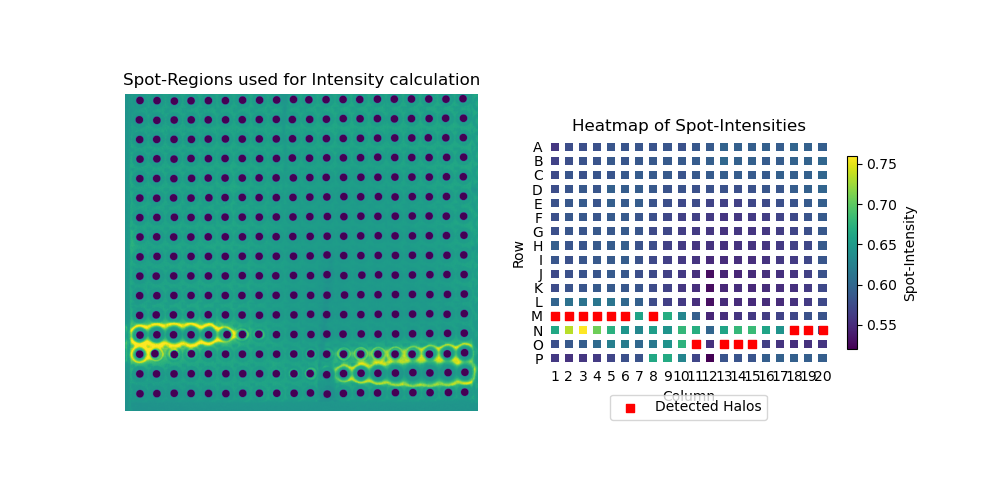

In [38]:
spot_img=raw_img.copy()
sort_spot["spot_intensity"]=np.nan

# Looping through all spots.
for idx in sort_spot.index:
    # Try to extract all pixel indices of the current spot, otherwise print an error.
    try:
        # Indices of all pixels part of the current spot
        rr,cc=skimage.draw.disk((sort_spot.loc[idx,"y_coord"],sort_spot.loc[idx,"x_coord"]),25)
        # Mean intensity of all pixels within the spot
        sort_spot.loc[idx,"spot_intensity"]=raw_img[rr,cc].sum()/len(rr)
        # Creating an image with all spots Highlighted
        spot_img[rr,cc]=0
    
    except:
        print(f"Spot at Coordinates ({sort_spot.loc[idx,'x_coord']}, {sort_spot.loc[idx,'y_coord']}) could not be drawn: Out of Bounds.")

# Create a heatmap of all spots of the current image
heatmap=sort_spot.pivot_table(index="row_letter",columns="column",values="spot_intensity")

# Display Image and corresponding Heatmap
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(spot_img)
ax[0].axis("off")
ax[0].set(title="Spot-Regions used for Intensity calculation")

htmp=ax[1].pcolormesh(heatmap.iloc[::-1],edgecolors="white",linewidth=4)
ax[1].set(title="Heatmap of Spot-Intensities",
          aspect="equal",
          ylabel="Row",
          xlabel="Column",
          yticks=np.array(range(1,len(heatmap)+1))-0.5,
          xticks=np.array(range(1,len(heatmap.columns)+1))-0.5,
          yticklabels=heatmap.index[::-1],
          xticklabels=heatmap.columns
          )
ax[1].spines[["right","left","top","bottom"]].set_visible(False)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
ax[1].scatter(sort_spot.loc[sort_spot["halo_rad"]>0,"column"]-colstart-0.5,row_nr-0.5-sort_spot.loc[sort_spot["halo_rad"]>0,"row"],marker="s", c="red",label="Detected Halos")
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True,ncol=5)
fig.colorbar(htmp,ax=ax[1],label="Spot-Intensity",shrink=0.5)
heatmap

## Save Results

In [39]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_spot.to_csv(outputfile)